In [62]:
# !pip install numpy scipy matplotlib wave

import numpy as np
# from scipy.ndimage import gaussian_filter1d
import scipy.signal as signal
import matplotlib.pyplot as plt
import Organ.readwav as readwav
from IPython.display import Audio

In [63]:
rate, array = readwav.readwav("./Organ/note_53.wav")
print("rate: ", rate)
print("array: ", array)

array = array.mean(axis=1)

# Seleziona solo una finestra stabile (es. dal 0.5s al 1s)
start = int(0.5 * rate)
end = int(4.0 * rate)
segment = array[start:end]

rate:  48000
array:  [[      1      -1]
 [     -3      -2]
 [      3       1]
 ...
 [  50245 -236786]
 [  47367 -237987]
 [  44503 -239119]]


In [64]:
# Applica una finestra Hann
window = signal.windows.blackmanharris(len(segment))
windowed = segment * window

In [65]:
# FFT
N = len(windowed)
T = 1.0 / rate
yf = np.fft.fft(windowed)
xf = np.fft.fftfreq(N, T)

In [66]:
# Spettro di potenza (solo parte positiva)
power = np.abs(yf[:N//2])**2
freqs = xf[:N//2]

In [67]:
# play the sound
Audio(array
       * signal.windows.taylor(len(array))
         ,rate=rate)

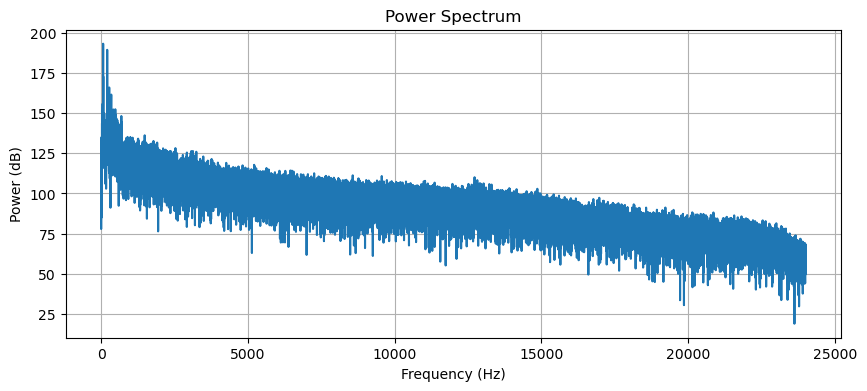

In [68]:
# Plot
plt.figure(figsize=(10, 4))
plt.plot(freqs, 10 * np.log10(power))
plt.title("Power Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.grid()
plt.show()

In [69]:
prominence = 20
peaks = np.array([], dtype = np.int64)
while(len(peaks)<4) :
    
    # Trova picchi con prominence adattiva
    peaks, _ = signal.find_peaks(np.log(power), prominence = prominence)
    
    prominence -= 1

# Frequenze dei picchi
peak_freqs = freqs[peaks]

print("Frequenze principali:", peak_freqs)


Frequenze principali: [   68.85714286   206.85714286   344.57142857 20137.14285714]


/tmp/ipykernel_7664/1249505660.py:2: RuntimeWarning: divide by zero encountered in log2
  plot_freqs = np.log2(freqs)


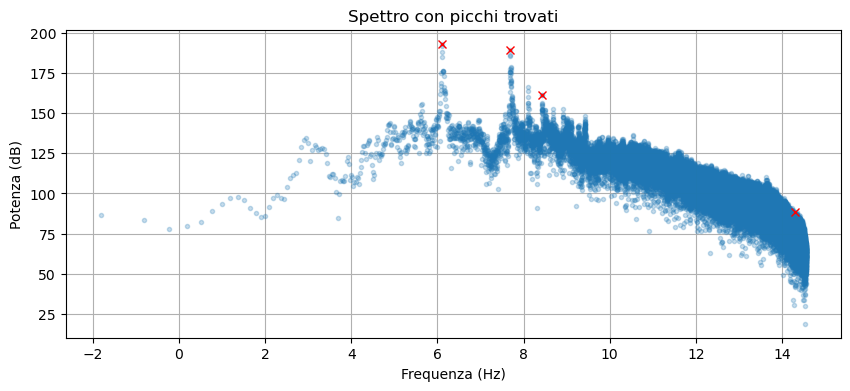

In [81]:
plt.figure(figsize=(10, 4))
plot_freqs = np.log2(freqs)
plt.plot(plot_freqs, 10 * np.log10(power), marker = '.', linestyle = '', alpha = 0.25)  # Spettro
plt.plot(plot_freqs[peaks], 10 * np.log10(power[peaks]), "rx")  # i picchi
plt.title("Spettro con picchi trovati")
plt.xlabel("Frequenza (Hz)")
plt.ylabel("Potenza (dB)")
plt.grid()
plt.show()

In [71]:

# Differenze tra frequenze dei picchi
#df = np.diff(peak_freqs)

# Approx. GCD
# def approx_gcd(arr, tol=0.1):
#     arr_int = (arr / tol).astype(int)
#     result = arr_int[0]
#     for val in arr_int[1:]:
#         result = np.gcd(result, val)
#     return result * tol

# f0_gcd = approx_gcd(peak_freqs)
# print(f"Frequenza fondamentale stimata (GCD): {f0_gcd} Hz")

print(np.diff(np.sort(peak_freqs)))

[  138.           137.71428571 19792.57142857]


In [72]:
frequenze_organo = 440 * 2 ** ((np.arange(-51, 41)) / 12)
print(f"{frequenze_organo.min()=}")
print(f"{frequenze_organo.max()=}")


frequenze_organo.min()=np.float64(23.12465141947715)
frequenze_organo.max()=np.float64(4434.922095629953)


In [73]:

def stima_fondamentale_gcd_robusto(peak_freqs, f_min=20., f_max=4000., tol=0.1):
    #diffs = np.diff(np.sort(peak_freqs))
    gcd_scores = {}

    for f0_cand in frequenze_organo:
        
        count = sum(
            np.abs((d % f0_cand)) < tol*f0_cand or np.abs(f0_cand - (d % f0_cand)) < tol*f0_cand
            for d in peak_freqs
        )
        gcd_scores[f0_cand] = count

    # Trova la frequenza con il punteggio massimo
    max_score = max(gcd_scores.values())  # Trova il punteggio massimo
    best_f0 = max(f for f, score in gcd_scores.items() if score == max_score)
    
    return best_f0, max_score, gcd_scores

best_f, max_score, scores = stima_fondamentale_gcd_robusto(peak_freqs)

print(f"Frequenza fondamentale stimata (GCD): {best_f} Hz")

print(scores)
print(max_score)


Frequenza fondamentale stimata (GCD): 3951.066410048992 Hz
{np.float64(23.12465141947715): np.int64(3), np.float64(24.499714748859326): np.int64(2), np.float64(25.956543598746574): np.int64(1), np.float64(27.5): np.int64(0), np.float64(29.13523509488062): np.int64(1), np.float64(30.86770632850775): np.int64(0), np.float64(32.70319566257483): np.int64(0), np.float64(34.64782887210901): np.int64(3), np.float64(36.70809598967594): np.int64(0), np.float64(38.890872965260115): np.int64(0), np.float64(41.20344461410875): np.int64(1), np.float64(43.653528929125486): np.int64(0), np.float64(46.2493028389543): np.int64(0), np.float64(48.999429497718666): np.int64(2), np.float64(51.91308719749314): np.int64(2), np.float64(55.0): np.int64(0), np.float64(58.27047018976124): np.int64(1), np.float64(61.7354126570155): np.int64(0), np.float64(65.40639132514966): np.int64(1), np.float64(69.29565774421802): np.int64(3), np.float64(73.41619197935188): np.int64(1), np.float64(77.78174593052023): np.int64

In [74]:
duration = 5
t = np.linspace(0, duration, int(rate * duration), endpoint=False)
sound = 10 * np.sin(2 * np.pi * best_f * t)
Audio(sound, rate=rate)

In [75]:
np.diff(np.log(peak_freqs))

array([1.09999446, 0.51027298, 4.06801988])